## Homework: Financial Ratio Quantile Strategies
### 18th January, 2023

In [414]:
import sys
sys.version

'3.10.8 (main, Nov 24 2022, 08:09:04) [Clang 14.0.6 ]'

In [415]:
%matplotlib inline

In [416]:
import matplotlib.pyplot as plt
plt.xkcd()

import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import statsmodels.api as sm
import math

pd.options.mode.chained_assignment = None 

## Introduction

In this study, I'm implementing a quantile-based long-short trading stategy.

Firstly, I imported data from Quandl and calculated financial ratios, including **debt to market cap**, **return on investment**, and **price to earnings**. After checking the correctness of ratio calculation with ticker LLY, I defined the universe by selecting tickers from US equities satisfying certain conditions. I implemented the quantile trading strategy using different ratios and their combinations. In the end, I further discussed some possible improments to the strategy.

## Financial Ratios Calculation

#### Functions

In [417]:
myAPIkey = "qUL_zooxYcHueGAiB-D-"
quandl.ApiConfig.api_key = myAPIkey

# get adjusted close price for a ticker
def get_adj_close(ticker,start_date,end_date):
    
    df = quandl.get_table('QUOTEMEDIA/PRICES', ticker=ticker,date = {'gte':start_date, 'lte':end_date})  
    df = df.sort_values(by='date')
    df = df[['date','adj_close']]    
    df = df.set_index(['date'])

    return df

# get quarterly data in zacks/fc for a ticker
def fill_zacks_fc(ticker,start_date,end_date):
    
    df_fc = quandl.get_table('ZACKS/FC',ticker = ticker,per_end_date = {'gte':start_date,'lte':end_date})
    
    df_fc = df_fc[df_fc.per_type == 'Q']   # avoid duplicate data
    df_fc = df_fc[['per_end_date','filing_date','eps_diluted_net','basic_net_eps','net_lterm_debt','tot_lterm_debt']]
    df_fc = df_fc.sort_values(by='per_end_date')
    
    df_fc['date'] = df_fc['per_end_date']
    df_fc = df_fc.set_index(['date'])
    
    return df_fc

# get quarterly data in zacks/fr for a ticker
def fill_zacks_fr(ticker,start_date,end_date):
    
    df_fr = quandl.get_table('ZACKS/FR',ticker = ticker,per_end_date = {'gte':start_date,'lte':end_date})
    
    df_fr = df_fr[df_fr.per_type == 'Q']   # avoid duplicate data
    df_fr = df_fr[['per_end_date', 'tot_debt_tot_equity','ret_invst']]
    df_fr = df_fr.sort_values(by='per_end_date')
    
    df_fr['date'] = df_fr['per_end_date']
    df_fr = df_fr.set_index(['date'])
    
    df_fr = df_fr[['tot_debt_tot_equity','ret_invst']]
       
    return df_fr

# get quarterly data in zacks/mktv for a ticker
def fill_zacks_mktv(ticker,start_date,end_date):
    
    df_mktv = quandl.get_table('ZACKS/MKTV',ticker = ticker,per_end_date = {'gte':start_date,'lte':end_date})
    
    df_mktv = df_mktv[['per_end_date', 'mkt_val']]
    df_mktv = df_mktv.sort_values(by='per_end_date')
    
    df_mktv['date'] = df_mktv['per_end_date']
    df_mktv = df_mktv.set_index(['date'])
    
    df_mktv = df_mktv[['mkt_val']]
    
    return df_mktv

# get quarterly data in zacks/shrs for a ticker
def fill_zacks_shrs(ticker,start_date,end_date):
    
    df_shrs = quandl.get_table('ZACKS/SHRS',ticker = ticker,per_end_date = {'gte':start_date,'lte':end_date})
    
    df_shrs = df_shrs[['per_end_date', 'shares_out']]
    df_shrs = df_shrs.sort_values(by='per_end_date')
    
    df_shrs['date'] = df_shrs['per_end_date']
    df_shrs = df_shrs.set_index(['date'])
    
    df_shrs = df_shrs[['shares_out']]
    
    return df_shrs

# combine quarterly data from ZFB
def generate_zacks_data(ticker,start_date,end_date):
    
    df_fc = fill_zacks_fc(ticker,start_date,end_date)
    df_fr = fill_zacks_fr(ticker,start_date,end_date)
    df_mktv = fill_zacks_mktv(ticker,start_date,end_date)
    df_shrs = fill_zacks_shrs(ticker,start_date,end_date)
    
    df = df_fc.join(df_fr)
    df = df.join(df_mktv)
    df = df.join(df_shrs)
    
    return df

# calculate debt to market cap ratio
def debt_to_market_cap(df,df_zack):

    df_tdte = df_zack[['per_end_date','filing_date','tot_debt_tot_equity']]

    df_tdte = df_tdte.join(df['adj_close'])   

    df_tdte['date'] = df_tdte['filing_date']
    df_tdte = df_tdte.set_index(['date'])
    df_tdte= df_tdte[['adj_close','tot_debt_tot_equity']]
    df_tdte = df_tdte.rename(columns={'adj_close': 'quarter_adj_close'})

    df_debt_to_market_cap = df[['adj_close']].join(df_tdte)

    # information released after market close
    df_debt_to_market_cap['quarter_adj_close'] = df_debt_to_market_cap['quarter_adj_close'].shift(1)  
    df_debt_to_market_cap['tot_debt_tot_equity'] = df_debt_to_market_cap['tot_debt_tot_equity'].shift(1)

    df_debt_to_market_cap['quarter_adj_close'] =  df_debt_to_market_cap['quarter_adj_close'].fillna(method='ffill')
    df_debt_to_market_cap['tot_debt_tot_equity'] =  df_debt_to_market_cap['tot_debt_tot_equity'].fillna(method='ffill')

    df_debt_to_market_cap['debt_to_market_cap'] = df_debt_to_market_cap['tot_debt_tot_equity']*df_debt_to_market_cap['quarter_adj_close']/df_debt_to_market_cap['adj_close']

    return df_debt_to_market_cap

# calculate return on investment ratio
def return_on_investment(df,df_zack):

    df_zack['net_lterm_debt'] = df_zack['net_lterm_debt'].fillna(df_zack['tot_lterm_debt'])
    df_zack['R'] = df_zack['ret_invst']*(df_zack['net_lterm_debt']+df_zack['mkt_val'])

    df_mkt_val = df_zack[['per_end_date','filing_date','mkt_val','net_lterm_debt','R']]
    df_mkt_val = df_mkt_val.join(df['adj_close'])   

    df_mkt_val['date'] = df_mkt_val['filing_date']
    df_mkt_val = df_mkt_val.set_index(['date'])
    df_mkt_val = df_mkt_val[['mkt_val','adj_close','net_lterm_debt','R']]
    df_mkt_val = df_mkt_val.rename(columns={'adj_close': 'quarter_adj_close'})

    df_mkt_val_daily = df[['adj_close']].join(df_mkt_val)

    # information released after market close
    df_mkt_val_daily['mkt_val'] =  df_mkt_val_daily['mkt_val'].shift(1)
    df_mkt_val_daily['quarter_adj_close'] =  df_mkt_val_daily['quarter_adj_close'].shift(1)
    df_mkt_val_daily['net_lterm_debt'] =  df_mkt_val_daily['net_lterm_debt'].shift(1)
    df_mkt_val_daily['R'] =  df_mkt_val_daily['R'].shift(1)

    df_mkt_val_daily['mkt_val'] =  df_mkt_val_daily['mkt_val'].fillna(method='ffill')
    df_mkt_val_daily['quarter_adj_close'] =  df_mkt_val_daily['quarter_adj_close'].fillna(method='ffill')
    df_mkt_val_daily['net_lterm_debt'] =  df_mkt_val_daily['net_lterm_debt'].fillna(method='ffill')
    df_mkt_val_daily['R'] =  df_mkt_val_daily['R'].fillna(method='ffill')

    df_mkt_val_daily['mkt_val_daily'] = df_mkt_val_daily['mkt_val']*df_mkt_val_daily['adj_close'] /df_mkt_val_daily['quarter_adj_close'] 
    
    df_mkt_val_daily['return_on_investment'] = df_mkt_val_daily['R']/(df_mkt_val_daily['net_lterm_debt']+df_mkt_val_daily['mkt_val_daily'])

    return df_mkt_val_daily

# calculate price to earnings ratio
def price_to_earnings(df,df_zack):

    # use the basic version if no diluted number is available
    df_zack['eps_diluted_net'] = df_zack['eps_diluted_net'].fillna(df_zack['basic_net_eps'])
    # treat negative earnings per share as 0.001
    df_zack.eps_diluted_net = np.where(df_zack.eps_diluted_net < 0, 0.001, df_zack.eps_diluted_net)

    df_pte = df_zack[['per_end_date','filing_date','eps_diluted_net']]  

    df_pte['date'] = df_pte['filing_date']
    df_pte= df_pte.set_index(['date'])
    df_pte = df_pte[['eps_diluted_net']]

    df_pte_daily = df[['adj_close']].join(df_pte)

    # information released after market close
    df_pte_daily['eps_diluted_net'] =  df_pte_daily['eps_diluted_net'].shift(1)
    df_pte_daily['eps_diluted_net'] =  df_pte_daily['eps_diluted_net'].fillna(method='ffill')

    df_pte_daily['price_to_earnings'] = df_pte_daily['adj_close']/(df_pte_daily['eps_diluted_net'])

    return df_pte_daily

# combine three financial ratios
def calculate_ratio(ticker,start_date,end_date):

    df_zack = generate_zacks_data(ticker,start_date,end_date)
    df_price = get_adj_close(ticker,start_date,end_date)

    df = df_price.join(df_zack,how='outer')
    df['adj_close'] =  df['adj_close'].fillna(method='ffill')

    df1 = debt_to_market_cap(df,df_zack)
    df2 = return_on_investment(df,df_zack)
    df3 = price_to_earnings(df,df_zack)

    df = df.join(df1['debt_to_market_cap'].to_frame())
    df = df.join(df2['return_on_investment'].to_frame())
    df = df.join(df3['price_to_earnings'].to_frame())

    return df[['adj_close','debt_to_market_cap','return_on_investment','price_to_earnings']]

#### Checking on sample data for Eli Lilly (LLY)

I'm choosing a time period a little longer than the period of Jan 2015 to Jan 2022 in ratios calculation and universe definition to enhance robustness.

In [418]:
start_date = '2014-06-30'
end_date = '2022-06-30'  

df_lly = calculate_ratio('LLY',start_date,end_date)

df_lly.loc[['2020-10-28','2020-10-29','2020-12-31','2021-01-04','2021-02-17','2021-02-18','2021-03-31','2021-04-01','2021-04-30']]

,adj_close,debt_to_market_cap,return_on_investment,price_to_earnings
date,,,,
2020-10-28,126.957708,4.755473,9.075546,81.908198
2020-10-29,128.156608,3.782411,6.317094,96.358352
2020-12-31,164.100327,2.953930,4.948484,123.383705
2021-01-04,160.854088,3.013544,5.047243,120.942923
2021-02-17,201.506221,2.405588,4.038046,151.508437
2021-02-18,196.294349,2.381655,7.910124,84.975909
2021-03-31,182.337461,2.563957,8.509632,78.933966
2021-04-01,180.795372,2.585826,8.581494,78.266395
2021-04-30,178.384637,2.620772,8.696299,77.222786


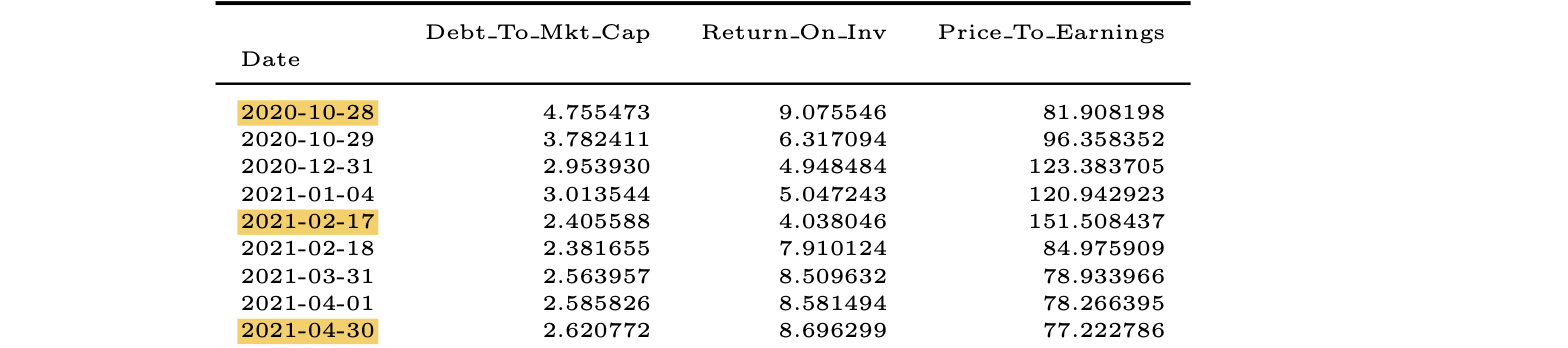

After checking with sample data of LLY, we could tell that the ratio calculations are correct.

## Define the Universe

The full list of available tickers (zacks-tickers.csv) contains 8912 tickers. I filtered the tickers using following steps, one after one.

1. Not in automotive, financial or insurance sector (zacks_sector_code not in [5,13]). Result is saved in filter_by_sector.csv.

2. End-of-day adjusted closing prices are available during the period. I did this by checking the length of adjusted close price dataframe after droping nan. Result is saved in filter_by_adj_close.csv.

3. Having feasible calculation of the ratios specified below. I did this by checking the length of quarterly dataframe to see if has sufficient quarterly data to compute ratios.

4. Debt to market cap ratio is greater than 0.1, preferably more than fleetingly. For this step, I counted the number of days which satisfy the condition (filtered1.csv) and filtered by setting different limits. 

In the end, I got universes containing 325,375, and 420 tickers. (filtered_ticker_325.csv, filtered_ticker_375.csv, filtered_ticker_420.csv)

Since it took a long time to filter the tickers, I'm presenting the functions and results here. The process could be seen in ipynbs in data processing folder.


#### Functions

In [419]:
def filter_by_sector(tickers_list_,new_ticker_list,zacks_sector_code_list,tickers_remove_list,start_date,end_date):

    for ticker in tickers_list_:

        if ticker in tickers_remove_list:
            continue

        df_fc = quandl.get_table('ZACKS/FC',ticker = ticker, per_end_date = {'gte':start_date,'lte':end_date},qopts={"columns":"zacks_sector_code"})

        if len(df_fc)!=0:
            sector_code_list = list(df_fc['zacks_sector_code'])

            if bool(set(zacks_sector_code_list) & set(sector_code_list))==False:
                new_ticker_list.append(ticker)

    return new_ticker_list

def filter_by_adj_close(tickers_list_,start_date,end_date,num):   # num should be same as LLY

    filter_by_adj_close_list = []

    for ticker in tickers_list_:
        df1 = get_adj_close(ticker,start_date,end_date)
        if len(df1) == num:
            filter_by_adj_close_list.append(ticker)

    return filter_by_adj_close_list

#### Universe defined

In [420]:
df_tickers = pd.read_csv('filtered_ticker_325.csv')  
df_tickers

,ticker
0,AAWW
1,ABT
2,ACCO
3,ACHC
4,ACIW
...,...
320,X
321,XRAY
322,XRX
323,YORW


In [421]:
ticker_list = list(df_tickers['ticker'])

## Ratios and rankings

After defining the universe, I computed the financial ratios for each ticker in the universe. The process took a long time so I'm still presenting functions and results here (debt_to_market_cap_325.csv, return_on_investment_325.csv,price_to_earnings_325.csv), the process could be seen in ther data processing folder.

#### Functions

In [422]:
# df_debt_to_market_cap = df_lly[:].drop(['adj_close','debt_to_market_cap','return_on_investment','price_to_earnings'], axis=1)
# df_return_on_investment = df_lly[:].drop(['adj_close','debt_to_market_cap','return_on_investment','price_to_earnings'], axis=1)
# df_price_to_earnings = df_lly[:].drop(['adj_close','debt_to_market_cap','return_on_investment','price_to_earnings'], axis=1)
# df_adj_close = df_lly[:].drop(['adj_close','debt_to_market_cap','return_on_investment','price_to_earnings'], axis=1)

# df_debt_to_market_cap1 = df_debt_to_market_cap[~df_debt_to_market_cap.index.duplicated(keep='first')]
# df_return_on_investment1 = df_return_on_investment[~df_return_on_investment.index.duplicated(keep='first')]
# df_price_to_earnings1 = df_price_to_earnings[~df_price_to_earnings.index.duplicated(keep='first')]

def build_ratio_dataframe(ticker_list,start_date,end_date):

    for ticker in ticker_list:

        # print(ticker)

        df_t = calculate_ratio(ticker,start_date,end_date)

        df_debt_to_market_cap = df_debt_to_market_cap.join(df_t['debt_to_market_cap'])
        df_debt_to_market_cap = df_debt_to_market_cap.rename(columns={'debt_to_market_cap': ticker})

        df_return_on_investment = df_return_on_investment.join(df_t['return_on_investment'])
        df_return_on_investment = df_return_on_investment.rename(columns={'return_on_investment': ticker})

        df_price_to_earnings = df_price_to_earnings.join(df_t['price_to_earnings'])
        df_price_to_earnings = df_price_to_earnings.rename(columns={'price_to_earnings': ticker})

        df_adj_close = df_adj_close.join(df_t['adj_close'])
        df_adj_close = df_adj_close.rename(columns={'adj_close': ticker})

In [423]:
def get_adj_close_dataframe(filepath):

    df_adj = pd.read_csv(filepath,index_col=0)
    df_adj = df_adj.loc['2015-01-01':'2022-01-31']

    df_adj = df_adj.fillna(method='ffill')  # fill possible nan/inf with value of previous day

    return df_adj 

def get_ratio_dataframe(filepath):

    df_ratio = pd.read_csv(filepath,index_col=0)
    df_ratio = df_ratio.loc['2015-01-01':'2022-01-31']

    df_ratio = df_ratio.replace([np.inf, -np.inf], np.nan)
    # df_ratio = df_ratio.fillna(method='ffill')  # fill possible nan/inf with value of previous day
    df_ratio = df_ratio.apply(lambda x: x.fillna(x.mean()),axis=0)  # fill possible nan/inf with average ratio value of the ticker
    # df_ratio = df_ratio.apply(lambda row: row.fillna(row.mean()), axis=1)  # fill possible nan/inf with average of the row

    return df_ratio 

#### Result

In [424]:
df_debt_to_market_cap = get_ratio_dataframe('ratio_debt_to_market_cap_325.csv')
df_return_on_investment = get_ratio_dataframe('ratio_return_on_investment_325.csv')
df_price_to_earnings = get_ratio_dataframe('ratio_price_to_earnings_325.csv')

In [425]:
df_debt_to_market_cap.head()

,AAWW,ABT,ACCO,ACHC,ACIW,ACM,ADM,AEP,AES,AIMC,...,WEX,WM,WMB,WTS,WWW,X,XRAY,XRX,YORW,ZBH
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1.004307,0.332626,0.966785,0.938788,1.729327,0.491293,0.267429,0.969831,2.871560,0.954448,...,1.261020,1.635962,1.223843,0.291060,0.977818,1.314769,0.450004,0.598621,0.724174,0.228452
2015-01-05,1.042413,0.332552,0.985852,0.952444,1.769732,0.513809,0.277014,0.984318,2.955700,0.990570,...,1.317497,1.652568,1.274285,0.298655,0.987341,1.379081,0.453145,0.611974,0.726741,0.220236
2015-01-06,1.065014,0.336371,1.011671,0.967666,1.798683,0.518996,0.282585,0.978956,3.023856,1.013812,...,1.345669,1.651278,1.291834,0.304415,1.011620,1.422282,0.458839,0.620275,0.733895,0.222119
2015-01-07,1.046225,0.333666,1.020173,0.928723,1.791122,0.508552,0.278400,0.965254,3.019215,1.017982,...,1.322318,1.649991,1.298807,0.306710,1.001272,1.418819,0.447248,0.612429,0.713464,0.216729
2015-01-08,1.008682,0.326946,0.977910,0.911731,1.793006,0.493243,0.282528,0.956998,2.973573,1.006688,...,1.284714,1.631234,1.286429,0.303557,0.976137,1.388392,0.436472,0.596021,0.701863,0.214452


In [426]:
df_return_on_investment.head()

,AAWW,ABT,ACCO,ACHC,ACIW,ACM,ADM,AEP,AES,AIMC,...,WEX,WM,WMB,WTS,WWW,X,XRAY,XRX,YORW,ZBH
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.644250,1.517516,1.641896,1.108146,1.082907,2.251344,2.853937,1.252275,1.992548,1.400091,...,6.786871,1.743871,4.967058,1.638539,2.472775,-4.411265,1.800576,1.357458,1.432706,1.934236
2015-01-05,0.663473,1.517195,1.675123,1.122582,1.107829,2.361059,2.960027,1.271246,2.050216,1.454613,...,7.049361,1.761592,5.143491,1.681397,2.497312,-4.647781,1.813293,1.388408,1.437784,1.864682
2015-01-06,0.674734,1.533708,1.720171,1.138623,1.125675,2.386417,3.021809,1.264224,2.096900,1.489756,...,7.179151,1.760216,5.204424,1.713898,2.559907,-4.807854,1.836350,1.407665,1.451939,1.880622
2015-01-07,0.665380,1.522015,1.735017,1.097478,1.121015,2.335387,2.975389,1.246282,2.093721,1.496067,...,7.071623,1.758843,5.228571,1.726847,2.533220,-4.794986,1.789421,1.389464,1.411515,1.834988
2015-01-08,0.646472,1.492928,1.661280,1.079415,1.122176,2.260823,3.021172,1.235477,2.062461,1.478980,...,6.897368,1.738825,5.185682,1.709056,2.468444,-4.682198,1.745820,1.351433,1.388561,1.815713


In [427]:
df_price_to_earnings.head()

,AAWW,ABT,ACCO,ACHC,ACIW,ACM,ADM,AEP,AES,AIMC,...,WEX,WM,WMB,WTS,WWW,X,XRAY,XRX,YORW,ZBH
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,44.018182,106.778880,25.874089,139.488372,140.785714,46.928060,36.409194,45.895088,15.550752,100.729803,...,52.518325,75.741063,12.378770,90.942452,45.823289,24822.050885,93.877236,31.631135,84.348636,104.648069
2015-01-05,42.409091,106.802661,25.373680,137.488372,137.571429,44.871575,35.149361,45.219608,15.108066,97.056626,...,50.267016,74.979993,11.888766,88.629498,45.381314,23664.497553,93.226441,30.941001,84.050716,108.551812
2015-01-06,41.509091,105.589805,24.726092,135.325581,135.357143,44.423168,34.456452,45.467284,14.767539,94.831529,...,49.214660,75.038537,11.727256,86.952606,44.292163,22945.694275,92.069471,30.526920,83.231436,107.631647
2015-01-07,42.254545,106.445939,24.520041,141.000000,135.928571,45.335443,34.974384,46.112742,14.790240,94.443020,...,50.083770,75.097081,11.664294,86.302088,44.749922,23001.704920,94.455721,30.917996,85.614797,110.308493
2015-01-08,43.827273,108.633836,25.579731,143.627907,135.785714,46.742512,34.463451,46.510525,15.017259,95.502590,...,51.549738,75.960602,11.776530,87.198358,45.902213,23505.800726,96.787738,31.769161,87.029917,111.479616


In [428]:
df_adj_close = get_adj_close_dataframe("adj_close_325.csv")
df_adj_close.head()

,AAWW,ABT,ACCO,ACHC,ACIW,ACM,ADM,AEP,AES,AIMC,...,WEX,WM,WMB,WTS,WWW,X,XRAY,XRX,YORW,ZBH
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,48.42,38.440397,7.503486,59.98,19.71,30.033958,41.506481,46.354039,10.419004,25.182451,...,100.31,43.929817,27.480869,58.203169,26.119275,24.822051,48.816163,27.835398,19.400186,105.694549
2015-01-05,46.65,38.448958,7.358367,59.12,19.26,28.717808,40.070271,45.671804,10.122404,24.264157,...,96.01,43.488396,26.393059,56.722879,25.867349,23.664498,48.477749,27.228081,19.331665,109.637330
2015-01-06,45.66,38.012330,7.170567,58.19,18.95,28.430828,39.280355,45.921957,9.894251,23.707882,...,94.00,43.522352,26.034508,55.649668,25.246533,22.945694,47.876125,26.863690,19.143230,108.707963
2015-01-07,46.48,38.320538,7.110812,60.63,19.03,29.014684,39.870797,46.573870,9.909461,23.610755,...,95.66,43.556307,25.894733,55.233336,25.507456,23.001705,49.116975,27.207837,19.691403,111.411578
2015-01-08,48.21,39.108181,7.418122,61.76,19.01,29.915208,39.288334,46.975630,10.061563,23.875648,...,98.46,44.057149,26.143896,55.806949,26.164261,23.505801,50.329624,27.956862,20.016881,112.594413


In [429]:
# check

print(df_debt_to_market_cap.loc['2021-04-01']['LLY'])   # 2.585826
print(df_return_on_investment.loc['2021-08-03']['LLY'])   # 4.324818
print(df_price_to_earnings.loc['2022-01-03']['LLY'])   # 219.754660

2.5858262750235936
4.324817877167752
219.7546603749853


## Quantile Trading Strategy

To construct a top-and-bottom decile trading strategy, I firstly rank the tickers using different ratios or combinations of ratios. The strategy assumes that tickers with higher rankings would have better performance, as a result, every time I update positions, I would go long top decile tickers and go short bottom decile tickers, the number of tickers depends on the quantile I select. I adjusted the position size to keep the capital size of long and short positions are the same as the initial capital.

I did the following studies:

* performance of three financial ratios 
* different quantiles
* rank the tickers using changes in ratios instead of ratios themselves
* rank on combinations of ratios
* sizing positions by rank

#### Functions

In [430]:
def buy_sell_position(x,buy_quantile,sell_quantile):

    if x <= buy_quantile:
        return 1

    elif x >= sell_quantile:
        return -1
   
    else:
        return 0

def adjust_position_row(x,long_ratio,short_ratio):

    if x == 1:
        return long_ratio
    elif x == -1:
        return (-1)*short_ratio
    else:
        return x

def quantile_trading(df_ratio,df_adj_close,ticker_num,quantile,frequency='D',ascending = False):

    df_ratio_rank = df_ratio.assign(**df_ratio.iloc[:, :].rank(axis = 1, ascending = ascending).astype(int))

    buy_quantile = int(quantile*ticker_num)   # buy ranking <= buy_quantile 
    sell_quantile = ticker_num - buy_quantile + 1   # sell ranking >= buy_quantile 

    # df_position = df_ratio_rank.applymap(buy_sell_position)

    df_position = df_ratio_rank.applymap(lambda x: buy_sell_position(x,buy_quantile,sell_quantile))

    first_month_long = list(df_position.columns[df_position.iloc[0]==1])
    first_month_short = list(df_position.columns[df_position.iloc[0]==-1])

    first_month_long_capital = sum(df_adj_close.iloc[0][first_month_long])
    first_month_short_capital = sum(df_adj_close.iloc[0][first_month_short])

    # first_month_long = list(df_position.columns[df_position.loc['2015-01-02']==1])
    # first_month_short = list(df_position.columns[df_position.loc['2015-01-02']==-1])

    # first_month_long_capital = sum(df_adj_close.loc['2015-01-02'][first_month_long])
    # first_month_short_capital = sum(df_adj_close.loc['2015-01-02'][first_month_short])

    initial_capital = (first_month_long_capital+first_month_short_capital)*10

    side_capital = initial_capital/2

    df_position_adjusted = df_position[:]

    # print(len(df_position))

    for index, row in df_position.iterrows():

        # print(index)

        month_long = list(df_position.columns[df_position.loc[index]==1])
        month_short = list(df_position.columns[df_position.loc[index]==-1])

        month_long_capital = sum(df_adj_close.loc[index][month_long])
        month_short_capital = sum(df_adj_close.loc[index][month_short])

        # if month_long_capital!=0 and month_short_capital!=0:

        long_ratio = side_capital*(1/month_long_capital)
        short_ratio = side_capital*(1/month_short_capital)

        df_position_adjusted.loc[index] = df_position.loc[index].map(lambda x: adjust_position_row(x,long_ratio,short_ratio))
        
        # else:
        #     continue
            # df_position_adjusted.loc[index] = df_position.loc[index].map(lambda x: adjust_position_row(x,long_ratio,short_ratio))

    
    # weekly/monthly

    if frequency != 'D':

        df_position_adjusted = df_position_adjusted.reset_index().set_index('date',drop=False)
        df_position_adjusted['date'] = pd.to_datetime(df_position_adjusted['date'])
        df_position_adjusted['freq_start'] = df_position_adjusted['date'].dt.to_period(frequency).apply(lambda r: r.start_time)

        df_position_adjusted['new_position'] = (df_position_adjusted['freq_start'] == df_position_adjusted['date'])

        df_new_position = df_position_adjusted[['new_position']]

        df_position_adjusted = df_position_adjusted.drop(columns=['date','new_position','freq_start'])

        for c in df_position_adjusted:

            df_position_adjusted[c] = np.where(df_new_position['new_position']==False, math.nan, df_position_adjusted[c])

        df_position_adjusted = df_position_adjusted.fillna(method='ffill')

        df_position_adjusted = df_position_adjusted.dropna()
        
    # calculate pnl

    r = 4.7*0.01  # Funding rate: 3 month LIBOR (4.7%)
    repo = r - 100 * 0.0001
    
    df_pnl = df_position[:].drop(ticker_list, axis=1)

    df_pnl['pnl'] = 0.0
    df_pnl['cumulative_pnl'] = 0.0
    df_pnl['cumulative_return'] = 0.0

    for i in range(len(df_position_adjusted)):

        if i == 0:
            continue

        pnl = sum(df_position_adjusted.iloc[i-1]*(df_adj_close.iloc[i]-df_adj_close.iloc[i-1]))

        df_pnl['pnl'][i] = pnl
        df_pnl['cumulative_pnl'][i] = df_pnl['cumulative_pnl'][i-1]+df_pnl['pnl'][i]
        df_pnl['cumulative_return'][i] = df_pnl['cumulative_pnl'][i]/initial_capital

    df_pnl['ret'] = df_pnl['pnl'] / initial_capital
    df_pnl['net_ret'] = df_pnl['ret'] - repo / 365
    df_pnl['cumulative_net_ret'] = (df_pnl['net_ret'] + 1).cumprod()

    df_pnl = df_pnl[:1730]

    return df_pnl

In [431]:
def performance_metrics(df, ratio, returns_plot_show = False, pnl_plot_show = False):
    
    # returns = df['cumulative_return'].to_frame()
    returns = df['ret'].to_frame()
    cumulative_returns = df['cumulative_net_ret'].to_frame()
    cumulative_pnl = df['cumulative_pnl'].to_frame()
    
    metrics = pd.DataFrame(index=returns.columns)
    
    metrics['Mean'] = round(returns.mean(),6)
    metrics['Vol'] = round(returns.std(),6)
    metrics['Sharpe'] = round(returns.mean()/returns.std(),4)

    metrics['Min'] = min(df['cumulative_net_ret'])
    metrics['Max'] = max(df['cumulative_net_ret'])

    # metrics['Max Drawdown'] = (returns['cumulative_return'] - 
    #                            returns['cumulative_return'].rolling(len(returns['cumulative_return']), 
    #                                                              min_periods=1).max()).min()
        
    metrics['Max Drawdown'] = (cumulative_returns['cumulative_net_ret'] - 
                               cumulative_returns['cumulative_net_ret'].rolling(len(cumulative_returns['cumulative_net_ret']), 
                                                                 min_periods=1).max()).min()
        
    if returns_plot_show == True:
        cumulative_returns.plot(title="Cumulative Net Return - Ratio: " +ratio, ylabel = "cumulative net return (%)" ,figsize = (12,5))
        
    if pnl_plot_show == True:
        cumulative_pnl.plot(title="Cumulative PnL - Ratio: " +ratio,figsize = (12,5))

    metrics = metrics.rename(index={'ret': ratio})
        
    return metrics

#### Performance of three financial ratios

Below are the results of using three different financial ratios. I omitted the weekly trading, because monthly trading always have a better result than weekly.

* **Debt to market cap**

In [432]:
ticker_num = 325
quantile = 0.15

df_dtmc = quantile_trading(df_debt_to_market_cap,df_adj_close,ticker_num,quantile,frequency='M',ascending=True)
performance_metrics(df_dtmc, 'Debt to Market Cap', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Debt to Market Cap,0.000343,0.002982,0.1151,0.996101,1.508179,-0.067345


* **Return on investment**

In [370]:
ticker_num = 325
quantile = 0.15

df_roi = quantile_trading(df_return_on_investment,df_adj_close,ticker_num,quantile,frequency='M')
performance_metrics(df_roi, 'Return on Investment', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Return on Investment,0.000477,0.007279,0.0656,0.974247,1.999922,-0.411252


* **Price to earnings**

In [302]:
ticker_num = 325
quantile = 0.15

df_pte = quantile_trading(df_price_to_earnings,df_adj_close,ticker_num,quantile,frequency = 'M',ascending=True)
performance_metrics(df_pte, 'Price to Earnings', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Price to Earnings,0.000249,0.00507,0.049,0.934305,1.293841,-0.174346


**Comparison**

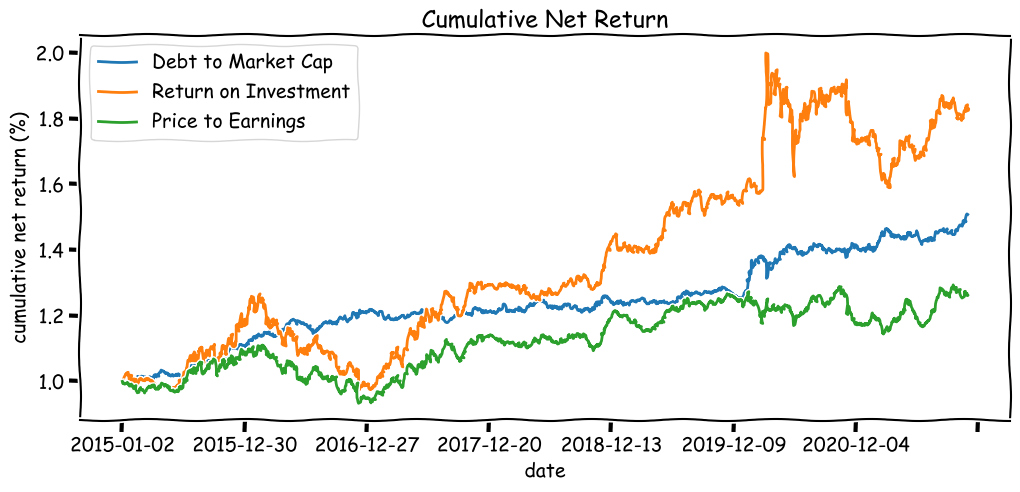

In [308]:
df_compare = df_dtmc[['cumulative_net_ret']]
df_compare = df_compare.rename(columns={'cumulative_net_ret': 'Debt to Market Cap'})
df_compare['Return on Investment'] = df_roi['cumulative_net_ret']
df_compare['Price to Earnings'] = df_pte['cumulative_net_ret']

df_compare.plot(title="Cumulative Net Return", ylabel = "cumulative net return (%)" ,figsize = (12,5));

According to the above results, using **return on investment** ratio could achieve the highest cumulative net return, while using **debt to market cap** ratio could achieve the best Sharpe ratio.

#### Choosing different quantiles

We are using **return on investment** ratio to discuss the influence of different quantiles.

* **quantile = 0.05**

In [312]:
ticker_num = 325
quantile = 0.05

df_roi_5 = quantile_trading(df_return_on_investment,df_adj_close,ticker_num,quantile,frequency='M')
performance_metrics(df_roi_5, 'Return on Investment 5%', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Return on Investment 5%,0.000906,0.010661,0.085,0.981833,3.90687,-0.649533


* **quantile = 0.10**

In [313]:
ticker_num = 325
quantile = 0.10

df_roi_10 = quantile_trading(df_return_on_investment,df_adj_close,ticker_num,quantile,frequency='M')
performance_metrics(df_roi_10, 'Return on Investment 10%', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Return on Investment 10%,0.000624,0.008856,0.0705,0.957423,2.382161,-0.519641


* **quantile = 0.15**

In [315]:
ticker_num = 325
quantile = 0.15

df_roi_15 = quantile_trading(df_return_on_investment,df_adj_close,ticker_num,quantile,frequency='M')
performance_metrics(df_roi_15, 'Return on Investment 15%', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Return on Investment 15%,0.000477,0.007279,0.0656,0.974247,1.999922,-0.411252


* **quantile = 0.25**

In [316]:
ticker_num = 325
quantile = 0.25

df_roi_25 = quantile_trading(df_return_on_investment,df_adj_close,ticker_num,quantile,frequency='M')
performance_metrics(df_roi_25, 'Return on Investment 25%', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Return on Investment 25%,0.000296,0.005171,0.0572,0.977593,1.456731,-0.229398


**Comparison**

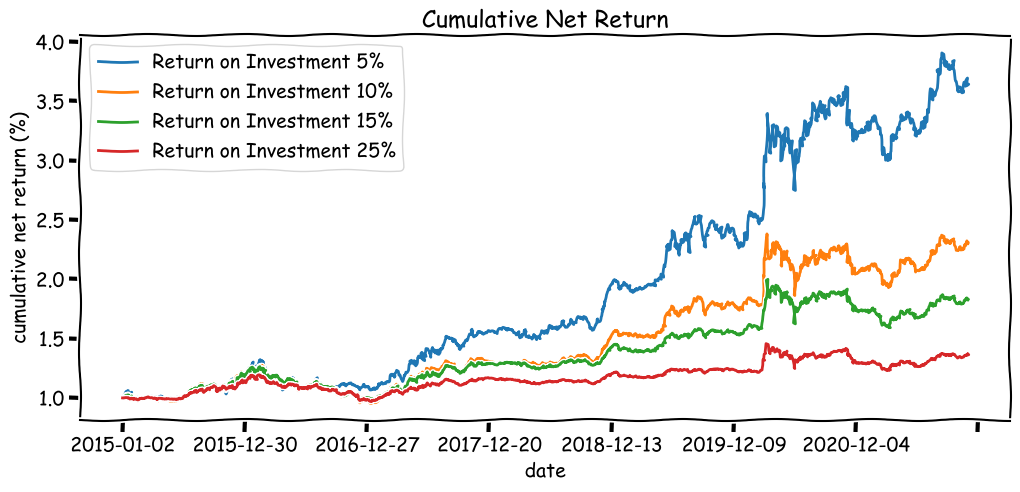

In [314]:
df_compare = df_roi_5[['cumulative_net_ret']]
df_compare = df_compare.rename(columns={'cumulative_net_ret': 'Return on Investment 5%'})
df_compare['Return on Investment 10%'] = df_roi_10['cumulative_net_ret']
df_compare['Return on Investment 15%'] = df_roi_15['cumulative_net_ret']
df_compare['Return on Investment 25%'] = df_roi_25['cumulative_net_ret']

df_compare.plot(title="Cumulative Net Return", ylabel = "cumulative net return (%)" ,figsize = (12,5));

According to the above results of applying different quantiles to **return on investment** ratio, the quantile gets smaller, the cumulative net return gets larger, and the performance gets better.

#### Rank based on changes in ratios

In [365]:
ticker_num = 325
quantile = 0.15

df_debt_to_market_cap_change = df_debt_to_market_cap.diff().dropna()
df_debt_to_market_cap_change[(df_debt_to_market_cap_change != 0.0).all(1)]
df_debt_to_market_cap_change = df_debt_to_market_cap_change.loc[~(df_debt_to_market_cap_change==0.0).all(axis=1)]
df_debt_to_market_cap_change = df_debt_to_market_cap_change.drop('2018-06-30')

df_dtmc_change = quantile_trading(df_debt_to_market_cap_change,df_adj_close,ticker_num,quantile,frequency='M',ascending=False)
performance_metrics(df_dtmc_change, 'Debt to Market Cap (Change)', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Debt to Market Cap (Change),0.000173,0.005111,0.0338,0.850825,1.122203,-0.216907


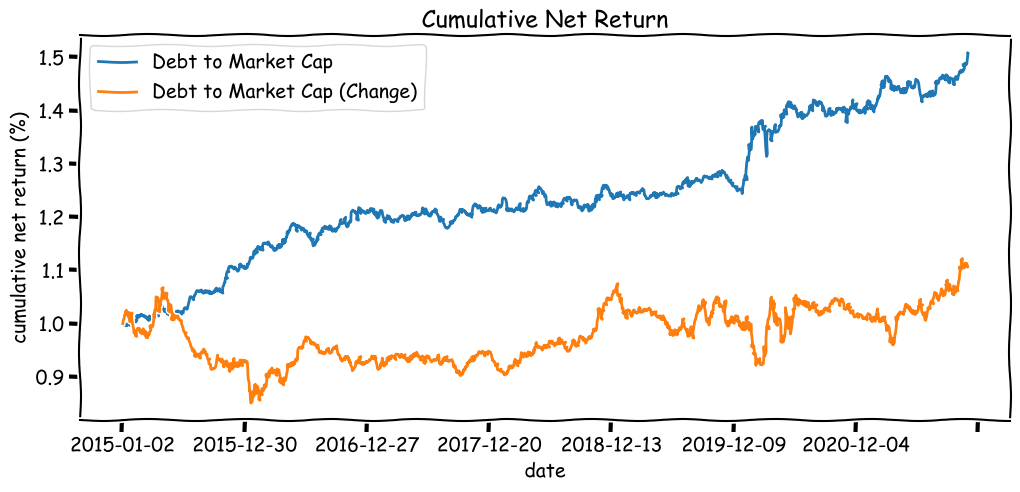

In [367]:
df_compare = df_dtmc[['cumulative_net_ret']]
df_compare = df_compare.rename(columns={'cumulative_net_ret': 'Debt to Market Cap'})
df_compare['Debt to Market Cap (Change)'] = df_dtmc_change['cumulative_net_ret']

df_compare.plot(title="Cumulative Net Return", ylabel = "cumulative net return (%)" ,figsize = (12,5));

Ranking based on changes in ratios apparently gives a worse result than using the original ratio.

#### Rank on combination of ratios

I further considered the combination of three financial ratios by assigning them with different weights, starting by equal weights.

In [385]:
# 100% weights to each ratio

df_dtmc_10 = quantile_trading(df_debt_to_market_cap,df_adj_close,ticker_num = 325, quantile = 0.1,frequency='M',ascending=True)
df_roi_10 = quantile_trading(df_return_on_investment,df_adj_close,ticker_num = 325, quantile = 0.1,frequency='M',ascending=False)
df_pte_10 = quantile_trading(df_price_to_earnings,df_adj_close,ticker_num = 325, quantile = 0.1,frequency='M',ascending=True)

In [386]:
df_dtmc_rank = df_debt_to_market_cap.assign(**df_debt_to_market_cap.iloc[:, :].rank(axis = 1, ascending = True).astype(int))
df_roi_rank = df_return_on_investment.assign(**df_return_on_investment.iloc[:, :].rank(axis = 1, ascending = False).astype(int))
df_pte_rank = df_price_to_earnings.assign(**df_price_to_earnings.iloc[:, :].rank(axis = 1, ascending = True).astype(int))

* **Debt to market cap 1/3, Return on investment 1/3, Price to earnings 1/3**

In [387]:
df_combination1 = df_dtmc_rank*(1/3) + df_roi_rank*(1/3) + df_pte_rank*(1/3)
df_c1 = quantile_trading(df_combination1,df_adj_close,ticker_num = 325, quantile = 0.1,frequency='M',ascending=True)
performance_metrics(df_c1, 'dtmc 0.33 roi 0.33 pte 0.33', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
dtmc 0.33 roi 0.33 pte 0.33,0.000621,0.00587,0.1058,0.97377,2.396787,-0.315544


* **Debt to market cap 30%, Return on investment 50%, Price to earnings 20%**

In [388]:
df_combination2 = df_dtmc_rank*0.3 + df_roi_rank*0.5 + df_pte_rank*0.2
df_c2 = quantile_trading(df_combination2,df_adj_close,ticker_num = 325, quantile = 0.1,frequency='M',ascending=True)
performance_metrics(df_c2, 'dtmc 0.30 roi 0.50 pte 0.20', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
dtmc 0.30 roi 0.50 pte 0.20,0.000624,0.006621,0.0943,0.976682,2.397701,-0.418162


* **Debt to market cap 45%, Return on investment 45%, Price to earnings 10%**

In [390]:
df_combination3 = df_dtmc_rank*0.45 + df_roi_rank*0.45 + df_pte_rank*0.1
df_c3 = quantile_trading(df_combination3,df_adj_close,ticker_num = 325, quantile = 0.1,frequency='M',ascending=True)
performance_metrics(df_c3, 'dtmc 0.45 roi 0.45 pte 0.10', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
dtmc 0.45 roi 0.45 pte 0.10,0.000618,0.005805,0.1064,0.980736,2.373334,-0.350401


**Comparison**

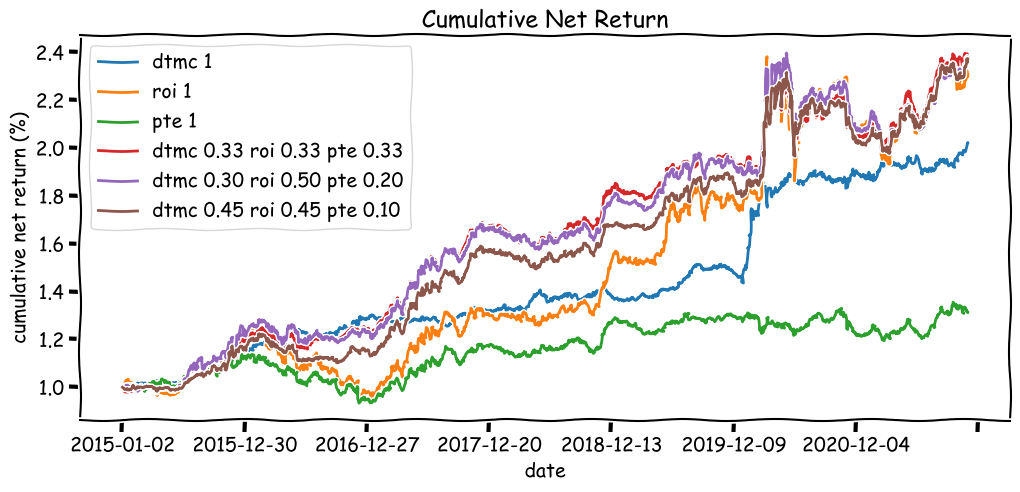

In [392]:
df_compare = df_dtmc_10[['cumulative_net_ret']]
df_compare = df_compare.rename(columns={'cumulative_net_ret': 'dtmc 1'})
df_compare['roi 1'] = df_roi_10['cumulative_net_ret']
df_compare['pte 1'] = df_pte_10['cumulative_net_ret']
df_compare['dtmc 0.33 roi 0.33 pte 0.33'] = df_c1['cumulative_net_ret']
df_compare['dtmc 0.30 roi 0.50 pte 0.20'] = df_c2['cumulative_net_ret']
df_compare['dtmc 0.45 roi 0.45 pte 0.10'] = df_c3['cumulative_net_ret']

df_compare.plot(title="Cumulative Net Return", ylabel = "cumulative net return (%)" ,figsize = (12,5));

According to the above plot, it is apparent that combining three financial ratios could achieve a better performance than using one individual ratio. Among the combinations, assigning equal weights to three ratios have a slightly better cumulative net return than those of other combinations.

#### Sizing positions by rank

In the above strategies, I'm assigning the same position sizes to tickers going long, and same position sizes to those going short. If I give larger position sizes to tickers with higher and lower rankings, will this help to improve the strategy? 

To find out this, in the following analysis, I choose quantile = 10%. In the mean time, I'm going to double the size of tickers in quantile 0%~5% and 95%~100%, comparing with tickers in 5%~10% and 90%~100%, and compare the performance with using the same position sizes.

##### Functions

In [402]:
def buy_sell_position2(x,buy_quantile1,buy_quantile2,sell_quantile1,sell_quantile2):

    if x <= buy_quantile2:
        return 2
    elif x> buy_quantile2 and x<= buy_quantile1:
        return 1
    elif x >= sell_quantile1 and x < sell_quantile2:
        return -1
    elif x>= sell_quantile2:
        return -2
    else:
        return 0


def adjust_position_row2(x,long_ratio,short_ratio):

    if x == 1:
        return long_ratio
    elif x == 2:
        return long_ratio*2
    elif x == -1:
        return (-1)*short_ratio
    elif x == -2:
        return (-2)*short_ratio
    else:
        return x

def quantile_trading2(df_ratio,df_adj_close,ticker_num,quantile,frequency='D',ascending = False):

    df_ratio_rank = df_ratio.assign(**df_ratio.iloc[:, :].rank(axis = 1, ascending = ascending).astype(int))

    buy_quantile1 = int(quantile*ticker_num)   # buy ranking <= buy_quantile 
    sell_quantile1 = ticker_num - buy_quantile1 + 1   # sell ranking >= buy_quantile 

    buy_quantile2 = int(buy_quantile1/2)
    sell_quantile2 = sell_quantile1 + buy_quantile2

    # df_position = df_ratio_rank.applymap(buy_sell_position)

    df_position = df_ratio_rank.applymap(lambda x: buy_sell_position2(x,buy_quantile1,buy_quantile2,sell_quantile1,sell_quantile2))

    first_month_long1 = list(df_position.columns[df_position.iloc[0]==1])
    first_month_long2 = list(df_position.columns[df_position.iloc[0]==2])
    first_month_short1 = list(df_position.columns[df_position.iloc[0]==-1])
    first_month_short2 = list(df_position.columns[df_position.iloc[0]==-2])

    first_month_long_capital = sum(df_adj_close.iloc[0][first_month_long1]) + 2*sum(df_adj_close.iloc[0][first_month_long2])
    first_month_short_capital = sum(df_adj_close.iloc[0][first_month_short1]) + 2*sum(df_adj_close.iloc[0][first_month_short2])

    initial_capital = (first_month_long_capital+first_month_short_capital)*10

    side_capital = initial_capital/2

    df_position_adjusted = df_position[:]

    for index, row in df_position.iterrows():

        month_long1 = list(df_position.columns[df_position.loc[index]==1])
        month_long2 = list(df_position.columns[df_position.loc[index]==2])
        month_short1 = list(df_position.columns[df_position.loc[index]==-1])
        month_short2 = list(df_position.columns[df_position.loc[index]==-2])

        month_long_capital = sum(df_adj_close.loc[index][month_long1]) + 2*sum(df_adj_close.loc[index][month_long2])
        month_short_capital = sum(df_adj_close.loc[index][month_short1]) + 2*sum(df_adj_close.loc[index][month_short2])

        long_ratio = side_capital*(1/month_long_capital)
        short_ratio = side_capital*(1/month_short_capital)

        df_position_adjusted.loc[index] = df_position.loc[index].map(lambda x: adjust_position_row2(x,long_ratio,short_ratio))
        
    # weekly/monthly

    if frequency != 'D':

        df_position_adjusted = df_position_adjusted.reset_index().set_index('date',drop=False)
        df_position_adjusted['date'] = pd.to_datetime(df_position_adjusted['date'])
        df_position_adjusted['freq_start'] = df_position_adjusted['date'].dt.to_period(frequency).apply(lambda r: r.start_time)

        df_position_adjusted['new_position'] = (df_position_adjusted['freq_start'] == df_position_adjusted['date'])

        df_new_position = df_position_adjusted[['new_position']]

        df_position_adjusted = df_position_adjusted.drop(columns=['date','new_position','freq_start'])

        for c in df_position_adjusted:

            df_position_adjusted[c] = np.where(df_new_position['new_position']==False, math.nan, df_position_adjusted[c])

        df_position_adjusted = df_position_adjusted.fillna(method='ffill')

        df_position_adjusted = df_position_adjusted.dropna()
        
    # calculate pnl

    r = 4.7*0.01  # Funding rate: 3 month LIBOR (4.7%)
    repo = r - 100 * 0.0001
    
    df_pnl = df_position[:].drop(ticker_list, axis=1)

    df_pnl['pnl'] = 0.0
    df_pnl['cumulative_pnl'] = 0.0
    df_pnl['cumulative_return'] = 0.0

    for i in range(len(df_position_adjusted)):

        if i == 0:
            continue

        pnl = sum(df_position_adjusted.iloc[i-1]*(df_adj_close.iloc[i]-df_adj_close.iloc[i-1]))

        df_pnl['pnl'][i] = pnl
        df_pnl['cumulative_pnl'][i] = df_pnl['cumulative_pnl'][i-1]+df_pnl['pnl'][i]
        df_pnl['cumulative_return'][i] = df_pnl['cumulative_pnl'][i]/initial_capital

    df_pnl['ret'] = df_pnl['pnl'] / initial_capital
    df_pnl['net_ret'] = df_pnl['ret'] - repo / 365
    df_pnl['cumulative_net_ret'] = (df_pnl['net_ret'] + 1).cumprod()

    df_pnl = df_pnl[:1730]

    return df_pnl

##### Result

In [404]:
buy_quantile1 = int(quantile*ticker_num)   # buy ranking <= buy_quantile 
sell_quantile1 = ticker_num - buy_quantile1 + 1   # sell ranking >= buy_quantile 

buy_quantile2 = int(buy_quantile1/2)
sell_quantile2 = sell_quantile1 + buy_quantile2

df_roi_sized = quantile_trading2(df_return_on_investment,df_adj_close,ticker_num = 325,quantile = 0.1,frequency='M',ascending = False)
performance_metrics(df_roi_sized, 'Return on Investment (Sized)', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Return on Investment (Sized),0.000706,0.009349,0.0755,0.972664,2.752432,-0.555019


* **Comparison**

In [407]:
df_roi_10 = quantile_trading(df_return_on_investment,df_adj_close,ticker_num = 325,quantile = 0.1,frequency='M',ascending = False)
performance_metrics(df_roi_10, 'Return on Investment', returns_plot_show = False, pnl_plot_show = False)

,Mean,Vol,Sharpe,Min,Max,Max Drawdown
Return on Investment,0.000624,0.008856,0.0705,0.957423,2.382161,-0.519641


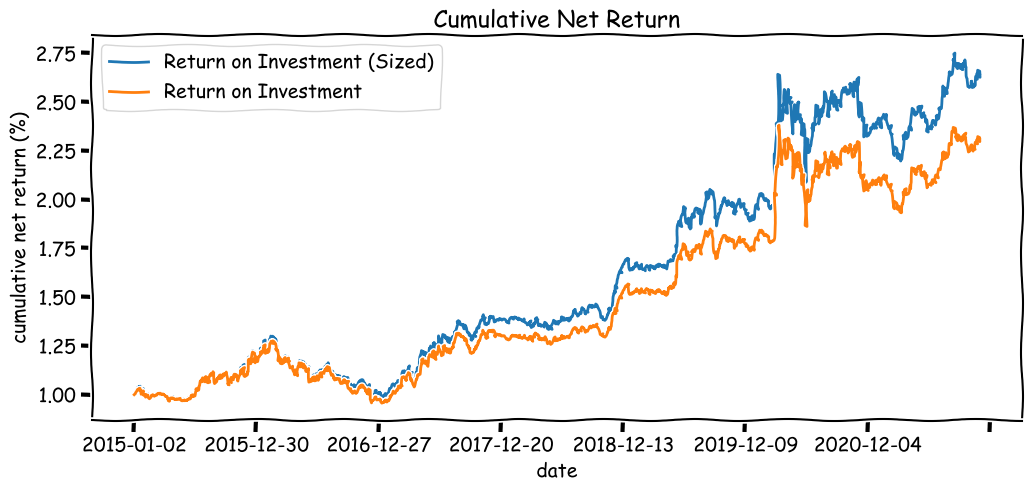

In [408]:
df_compare = df_roi_sized[['cumulative_net_ret']]
df_compare = df_compare.rename(columns={'cumulative_net_ret': 'Return on Investment (Sized)'})
df_compare['Return on Investment'] = df_roi_10['cumulative_net_ret']

df_compare.plot(title="Cumulative Net Return", ylabel = "cumulative net return (%)" ,figsize = (12,5));

Here I used **return on investment** ratio and quantile = 10%. 

Comparing the results of the two strategies, we could tell that sizing the positions by assigning more weights to the tickers in the tails could enhance the performance. By sizing the positions of quantile 5%, the performance has a better Sharpe ratio and cumulative net return.

## Possible improvements to the strategy

* Different universe. I'm using 325 tickers, however I didn't have time to use the 375 and 420 tickers that I filtered. The performance might be different if I try different universes.

* Better ways to size positions by rank. Here I just doubled the position sizes of quantile 0%~5% comparing with 5%~10%, which is a rough approach. We could consider better ways, like giving more layers of different quantiles, or even give each ticker in different ranking a different weight.

* Combinations. Here I tried some combinations, but I didn't spend time finding the best weights assigning to the ratios. We could actually write a function to automatically find the best combination.

* Different financial ratios. We are only using three financial ratios here, more ratios and their combinations might lead better results.

* Don't give up a ticker so fast if its ranking falls out of quantile. When updating positions in the beginning of each period, we drop a ticker if its ranking is no longer in the quantile. However it is possible to get back to the quantile in the next period, so we could draw a quantile as buffer zone. If a ticker falls out of quantile but stays in buffer zone, we could still keep long/short position of it unless it drops out of buffer zone or does not return to the quantile.

## Conclusion

In this study, I defined the universe of tickers by filtering based on conditioins, calculated financial ratios, ranked the tickers based on ratios, wrote quantile ratio strategies, and analyzed results. My discussions and findings gained from the results are as belows.

* **Return on investment** ratio achieved the highest cumulative net return, **debt to market cap** ratio achieved the best Sharpe ratio, **price to earnings** ratio performed the worst.

* For return on investment ratio, when applying different quantiles, the quantile gets smaller, the cumulative net return gets larger, and the performance gets better.

* Using changes in ratios gave a worse result than using ratios themselves.

* Cominations of ratios could achieve better performance than using ratios seperately.

* Sizing the positions by assigning more weights to the tickers in the tails could enhance the performance.